
## ====== Install specific libraries version to avoid dependency conflicts====

In [ ]:
!pip install optuna
!pip install shap==0.46.0
!pip install keras-tuner


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_training.csv")

In [ ]:
# Split features and target
X = df.drop('TNBC_Subtype', axis=1).values
y = df['TNBC_Subtype'].values

# Label encoding and one-hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for 1D CNN: (samples, features, 1)
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Input shape
input_shape = X_train.shape[1:]


In [ ]:
# Residual block
def residual_block(x, filters, kernel_size, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Project shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Build the CNN model
inputs = Input(shape=input_shape)
x = Conv1D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = residual_block(x, 128, 3)
x = residual_block(x, 256, 3)
x = residual_block(x, 512, 3)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 69, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 69, 64)    │        256 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 64)    │        256 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 69, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 69, 128)   │     24,704 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 128)   │        512 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 69, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 69, 128)   │          0 │ activation_22[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 69, 128)   │     49,280 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 128)   │        512 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 69, 128)   │      8,320 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 69, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 69, 128)   │          0 │ add_9[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 69, 256)   │     98,560 │ activation_23[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 256)   │      1,024 │ conv1d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 69, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 69, 256)   │          0 │ activation_24[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 69, 256)   │    196,864 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 69, 256)   │      1,024 │ conv1d_35[0][0] 

 Total params: 6,253,316 (23.85 MB)

 Trainable params: 6,249,604 (23.84 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.6107 - loss: 1.0236 - val_accuracy: 0.8607 - val_loss: 0.3646
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8438 - loss: 0.4290 - val_accuracy: 0.8831 - val_loss: 0.3239
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8542 - loss: 0.3881 - val_accuracy: 0.8850 - val_loss: 0.3100
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8643 - loss: 0.3616 - val_accuracy: 0.8944 - val_loss: 0.2875
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8738 - loss: 0.3335 - val_accuracy: 0.8901 - val_loss: 0.2961
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8893 - loss: 0.3126 - val_accuracy: 0.8953 - val_loss: 0.2789
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8911 - loss: 0.2935 - val_accuracy: 0.8981 - val_loss: 0.2773
Epoch 8/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8920 - loss: 0.2847 - val_acc

###========================== Model Evaluation ==========================

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9038 - loss: 0.3536
Test Loss: 0.36437731981277466
Test Accuracy: 0.901502251625061
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

--- Classification Report ---
              precision    recall  f1-score   support

         BL1       0.91      0.88      0.90      1436
         BL2       0.89      0.90      0.90      1495
         LAR       0.89      0.92      0.91      1933
           M       0.91      0.90      0.90      2192

    accuracy                           0.90      7056
   macro avg       0.90      0.90      0.90      7056
weighted avg       0.90      0.90      0.90      7056



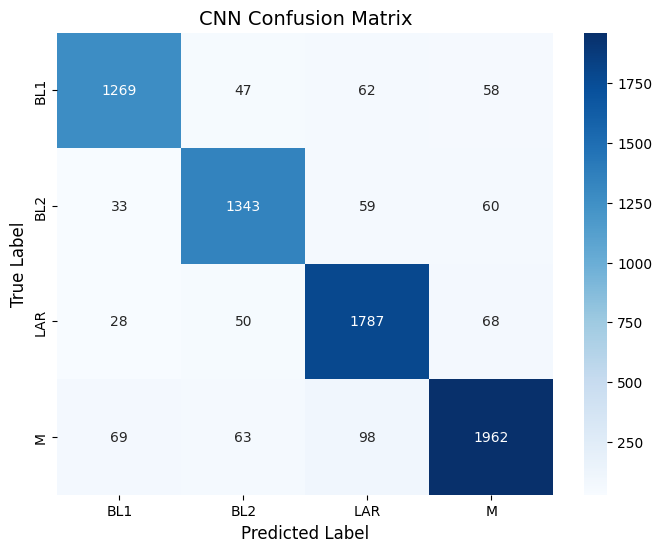

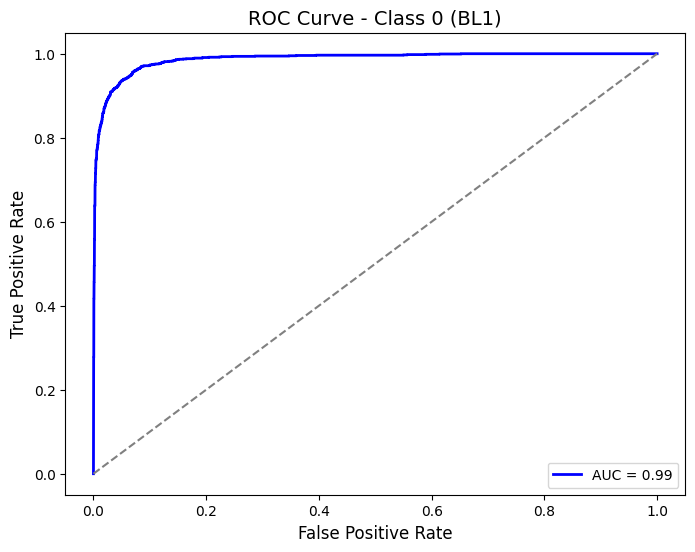

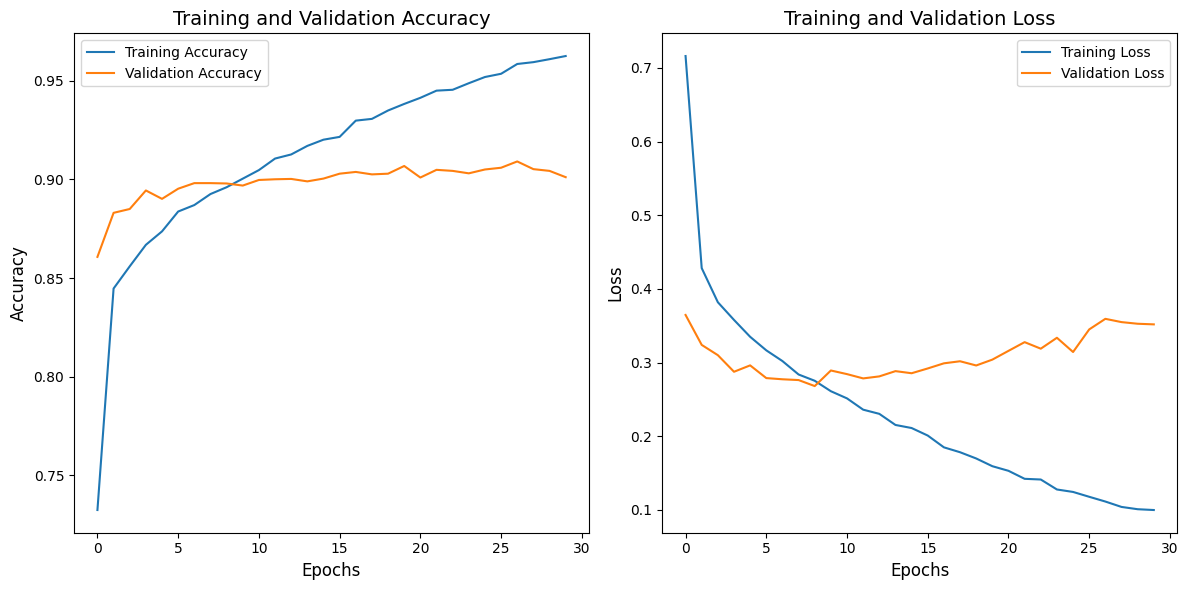


--- Model Metrics Summary ---
Test Loss: 0.3644
Test Accuracy: 0.9015


In [ ]:


# ==================== Metrics ====================
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification Report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=['BL1', 'BL2', 'LAR', 'M']))

# ==================== Confusion Matrix ====================
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['BL1', 'BL2', 'LAR', 'M'], yticklabels=['BL1', 'BL2', 'LAR', 'M'])
plt.title('CNN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# ==================== ROC Curve ====================
fpr, tpr, _ = roc_curve(y_true_labels, y_pred[:, 0], pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - Class 0 (BL1)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.show()

# ==================== Learning Curve ====================
# Plot learning curves for accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# ==================== Metrics Summary ====================
print("\n--- Model Metrics Summary ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:

# --- Create a Wrapper for Model Prediction ---
def predict_fn(input_data):
    # Ensure the input is reshaped to the expected shape for the model
    input_data_reshaped = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)  # (batch_size, features, 1)

    # Predict with the model and return as a numpy array (no need for .numpy())
    return model.predict(input_data_reshaped)  # Already a NumPy array

# --- Prepare SHAP Data ---
X_shap = X_test[:500]  # shape: (500, 69)

# Remove the last dimension (shape should become (500, 69))
X_shap_reshaped = X_shap.reshape(X_shap.shape[0], X_shap.shape[1])

# --- Initialize SHAP KernelExplainer ---
# Using shap.kmeans to summarize the background data (reduce size of background dataset)
background_data = shap.kmeans(X_shap_reshaped, 10)  # Using 10 clusters to summarize the background data

# Initialize SHAP KernelExplainer with the prediction function wrapper
explainer = shap.KernelExplainer(predict_fn, background_data)

# --- Compute SHAP values ---
shap_values = explainer.shap_values(X_shap_reshaped, nsamples=100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=6.496e-03, previous alpha=6.392e-03, with an active set of 10 regressors.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=1.170e-04, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=1.167e-04, with an active set of 37 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_it

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=2.381e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=1.080e-03, previous alpha=8.988e-04, with an active set of 33 regressors.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.245e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_ite

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.981e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 68 iterations, alpha=9.706e-03, previous alpha=9.572e-03, with an active set of 29 regressors.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 94 iterations, i.e. alpha=3.866e-06, with an active set of 46 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_ite

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=8.765e-04, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 53 iterations, alpha=2.710e-04, previous alpha=2.661e-04, with an active set of 40 regressors.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 48 iterations, alpha=6.563e-04, previous alpha=6.563e-04, with an active set of 37 regresso

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=4.009e-04, with an active set of 33 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 141 iterations, alpha=4.250e-05, previous alpha=4.250e-05, with an active set of 48 regressors.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.137e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=2.647e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.410e-03, with an active set of 26 regressors, and the smallest cholesky pivot element b

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.883e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 65 iterations, alpha=5.416e-03, previous alpha=5.407e-03, with an active set of 36 regressors.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.914e-03, with an active set of 27 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=1.868e-03, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 45 iterations, i.e. alpha=1.316e-03, with an active set of 35 regressors, and the smallest cholesky pivot element b

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

### SHAP Summary for Each TNBC Subtype
This section generates SHAP summary plots for each TNBC subtype to understand the feature importance across the subtypes. It also includes a plot for the top 10 features based on SHAP values and a waterfall plot to show the contribution of features to individual predictions.

SHAP shape after transpose: (4, 500, 69)

--- SHAP Summary for Subtype: Basal-like 2 (BL2) ---


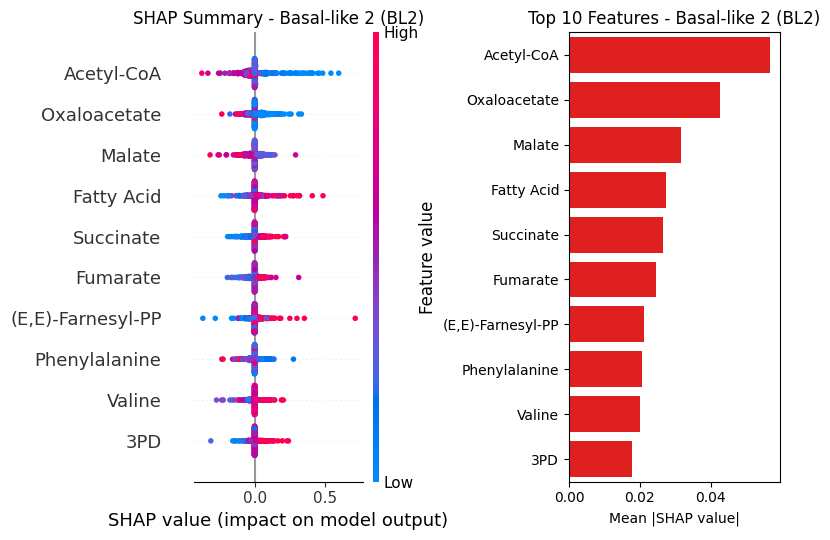


--- SHAP Summary for Subtype: Basal-like 1 (BL1) ---


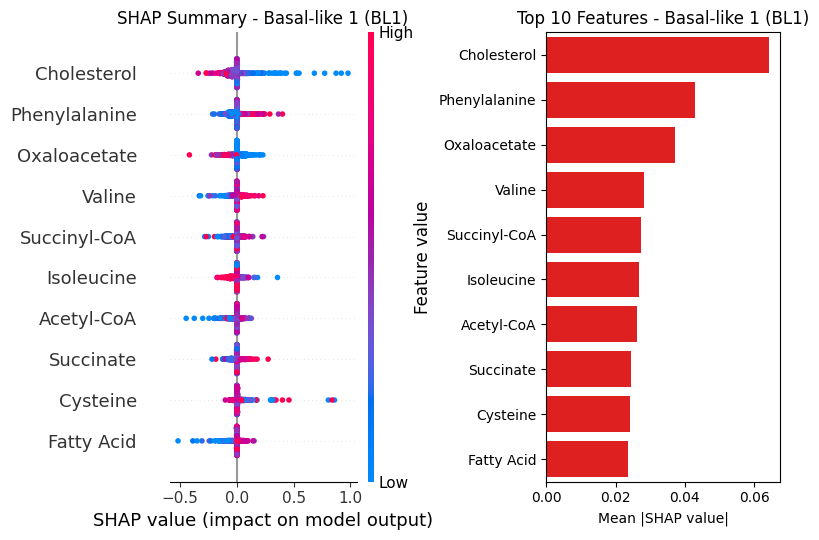


--- SHAP Summary for Subtype: Luminal Androgen Receptor (LAR) ---


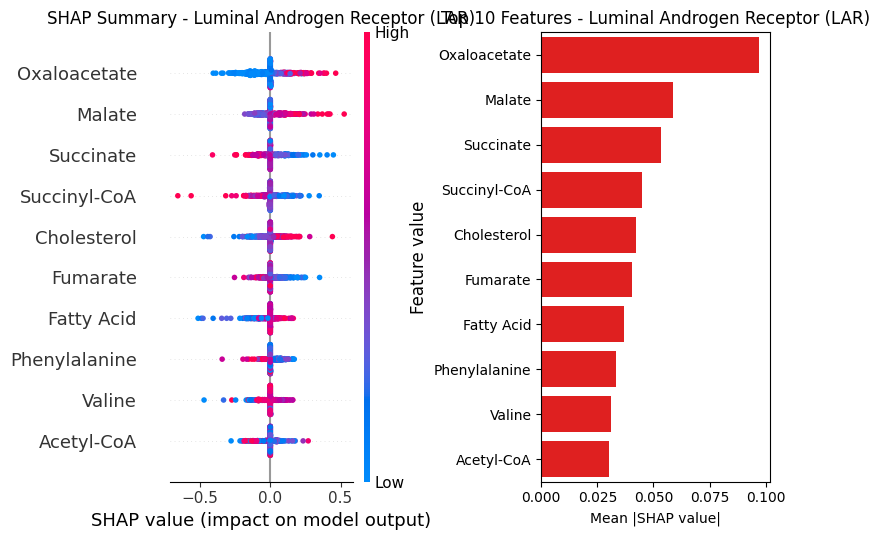


--- SHAP Summary for Subtype: Mesenchymal (M) ---


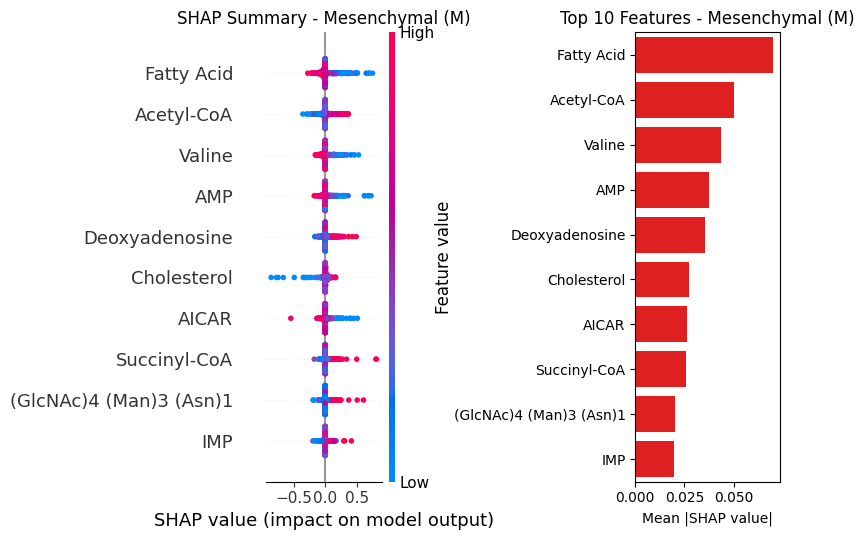

In [ ]:
# ==================== Fix feature_names (exclude target) ====================
feature_names = df.drop(columns=["TNBC_Subtype"]).columns.tolist() # Should be 69

# ==================== Fix X_shap input ====================
X_shap_fixed = X_shap[:500].reshape(500, 69)

# ==================== Get the actual subtype names from the dataset ====================
subtype_names = df['TNBC_Subtype'].unique()  # Get unique TNBC subtypes from your dataset

# ==================== Transpose SHAP values ====================
shap_values = np.transpose(shap_values, (2, 0, 1))  # Now shape = (classes, samples, features)
print("SHAP shape after transpose:", shap_values.shape)

# ==================== Loop over each subtype ====================
for i, subtype in enumerate(subtype_names):
    print(f"\n--- SHAP Summary for Subtype: {subtype} ---")

    # Compute the mean absolute SHAP value for ranking the features
    mean_shap = np.mean(np.abs(shap_values[i]), axis=0)

    # Get indices for the top 10 features
    top_indices = np.argsort(mean_shap)[-10:][::-1]

    # Filter SHAP values and features for top 10
    shap_values_top = shap_values[i][:, top_indices]
    X_test_top = X_shap_fixed[:, top_indices]
    top_feature_names = np.array(feature_names)[top_indices]

    # ==================== Plot SHAP Summary and Feature Importance ====================
    plt.figure(figsize=(14, 6))

    # SHAP Summary Plot for top 10 features (left)
    plt.subplot(1, 2, 1)
    shap.summary_plot(shap_values_top, X_test_top, feature_names=top_feature_names, plot_type='dot', show=False)
    plt.title(f"SHAP Summary - {subtype}")

    # Red bar plot of top 10 features (right)
    plt.subplot(1, 2, 2)
    top_importances = mean_shap[top_indices]
    sns.barplot(x=top_importances, y=top_feature_names, color='red')
    plt.title(f"Top 10 Features - {subtype}")
    plt.xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()


### Explanation of SHAP Summary Section:
SHAP Summary Plot: Generates the summary plot for the SHAP values of each class. This plot shows the distribution of SHAP values for each feature, helping visualize which features have the largest impact on the model's predictions.
Top 10 SHAP Summary Plot: Focuses only on the top 10 most important features by SHAP values, providing a clearer understanding of the features that drive predictions the most.
Waterfall Plot: Visualizes the contribution of each feature to the prediction for a specific instance (e.g., instance 0). It shows how much each feature shifted the prediction for that class.

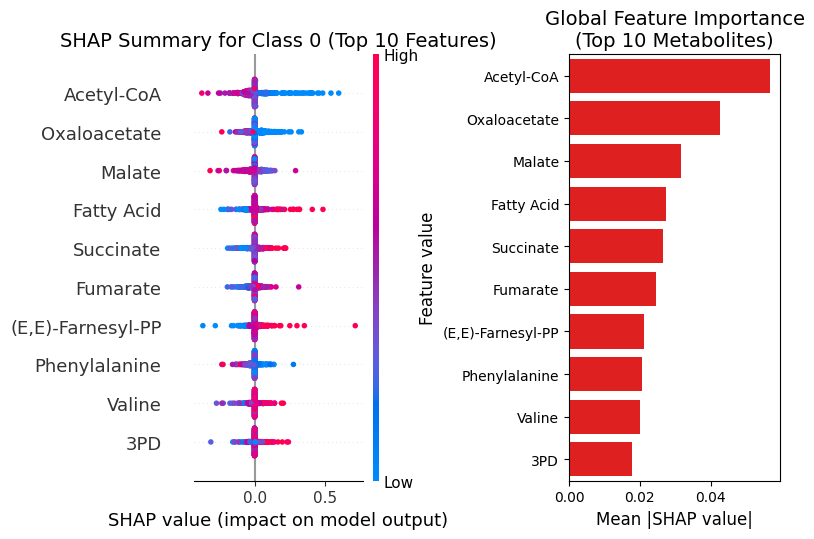

In [ ]:

# ==================== Fix feature_names (exclude target) ====================
feature_names = df.drop(columns=["TNBC_Subtype"]).columns.tolist()  # Should be 69

# ==================== Fix X_shap input ====================
X_shap_fixed = X_shap[:500].reshape(500, 69)

# ==================== FIX SHAP values ====================
# Your SHAP values are (500, 69, 4) → so select class 0
shap_vals_class_0 = shap_values[:, :, 0]  # (samples, features)

# ==================== Global Feature Importance ====================
shap_importance = np.mean(np.abs(shap_vals_class_0), axis=0)
sorted_idx = np.argsort(shap_importance)[-10:]  # Get top 10 metabolites
top_10_metabolites = np.array(feature_names)[sorted_idx]
top_10_importance = shap_importance[sorted_idx]

# ==================== Sort the Importance in Descending Order ====================
top_10_metabolites_sorted = top_10_metabolites[::-1]
top_10_importance_sorted = top_10_importance[::-1]

# ==================== Create a Figure for Side-by-Side Plots ====================
plt.figure(figsize=(16, 6))  # Adjust the figure size to accommodate both plots side by side

# ==================== SHAP Summary Plot (Left) ====================
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
shap.summary_plot(shap_vals_class_0, X_shap_fixed, feature_names=feature_names,
                  show=False, plot_type='dot', max_display=10)
plt.title("SHAP Summary for Class 0 (Top 10 Features)", fontsize=14)

# ==================== Feature Importance Bar Plot (Right) ====================
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
# Plot the feature importance bar plot with adjusted size and descending order
sns.barplot(x=top_10_importance_sorted, y=top_10_metabolites_sorted, color='red', orient='h')
plt.title('Global Feature Importance\n(Top 10 Metabolites)', fontsize=14)
plt.xlabel('Mean |SHAP value|', fontsize=12)

# Adjust the layout so that the plots don't overlap
plt.tight_layout()
plt.show()


##======USING UMAP DATAFRAME====

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam


In [3]:
df = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_umap_training.csv")

In [7]:
# Split features and target
X = df.drop('TNBC_Subtype', axis=1).values
y = df['TNBC_Subtype'].values

# Label encoding and one-hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for 1D CNN: (samples, features, 1)
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Input shape
input_shape = X_train.shape[1:]

# Split features and target
X = df.drop('TNBC_Subtype', axis=1).values
y = df['TNBC_Subtype'].values

# Label encoding and one-hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for 1D CNN: (samples, features, 1)
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Input shape
input_shape = X_train.shape[1:]

# ====Residual block model=========

def residual_block(x, filters, kernel_size, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Project shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Build the CNN model
inputs = Input(shape=input_shape)
x = Conv1D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = residual_block(x, 128, 3)
x = residual_block(x, 256, 3)
x = residual_block(x, 512, 3)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 128)   │     24,704 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 128)   │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 128)   │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 128)   │      8,320 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 10, 128)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 256)   │     98,560 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 256)   │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 256)   │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 10, 256)   │    196,864 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 256)   │      1,024 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,386,692 (9.10 MB)

 Trainable params: 2,382,980 (9.09 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8410 - loss: 0.4172 - val_accuracy: 0.9722 - val_loss: 0.0775
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9592 - loss: 0.1033 - val_accuracy: 0.9819 - val_loss: 0.0452
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9667 - loss: 0.0863 - val_accuracy: 0.9798 - val_loss: 0.0524
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9685 - loss: 0.0750 - val_accuracy: 0.9832 - val_loss: 0.0423
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9719 - loss: 0.0707 - val_accuracy: 0.9786 - val_loss: 0.0482
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9709 - loss: 0.0713 - val_accuracy: 0.9832 - val_loss: 0.0383
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9725 - loss: 0.0651 - val_accuracy: 0.9818 - val_loss: 0.0477
Epoch 8/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9758 - loss: 0.0581 - val_accuracy: 

221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9794 - loss: 0.0487
Test Loss: 0.044093888252973557
Test Accuracy: 0.980583906173706
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- Classification Report ---
              precision    recall  f1-score   support

         BL1       0.99      0.98      0.98      1436
         BL2       0.99      0.99      0.99      1495
         LAR       0.99      0.97      0.98      1933
           M       0.97      0.99      0.98      2192

    accuracy                           0.98      7056
   macro avg       0.98      0.98      0.98      7056
weighted avg       0.98      0.98      0.98      7056



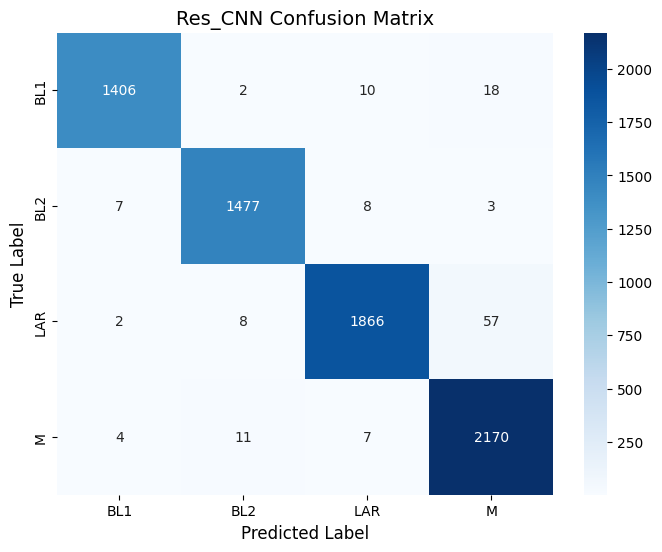

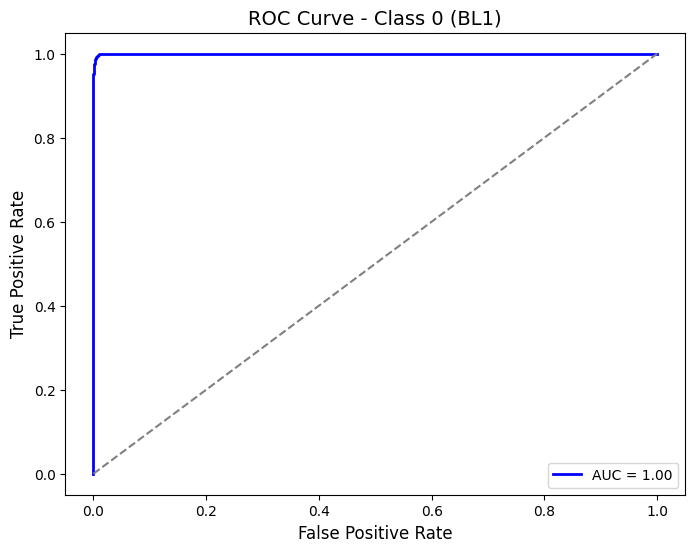

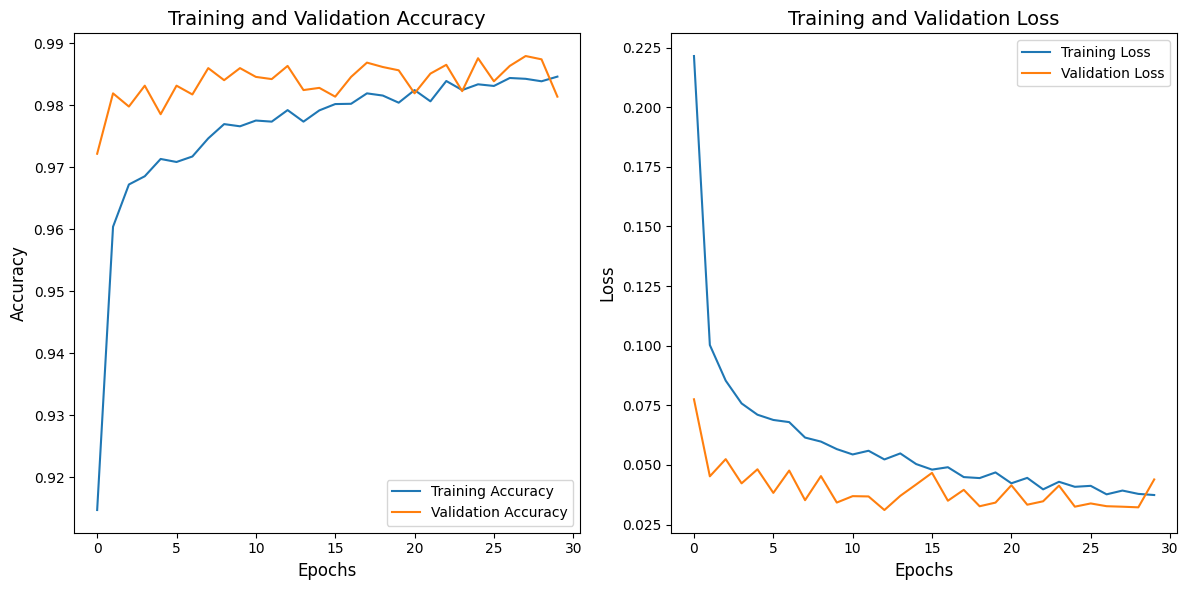


--- Model Metrics Summary ---
Test Loss: 0.0441
Test Accuracy: 0.9806


In [10]:


# ==================== Metrics ====================
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification Report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=['BL1', 'BL2', 'LAR', 'M']))

# ==================== Confusion Matrix ====================
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['BL1', 'BL2', 'LAR', 'M'], yticklabels=['BL1', 'BL2', 'LAR', 'M'])
plt.title('Res_CNN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# ==================== ROC Curve ====================
fpr, tpr, _ = roc_curve(y_true_labels, y_pred[:, 0], pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - Class 0 (BL1)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.show()

# ==================== Learning Curve ====================
# Plot learning curves for accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# ==================== Metrics Summary ====================
print("\n--- Model Metrics Summary ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
